In [ ]:
from hyperopt import hp, fmin, space_eval, STATUS_OK, tpe
from hyperopt.pyll import scope
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.preprocessing import StandardScaler
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, robust_scale, quantile_transform
from scipy.stats import boxcox
from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LogisticRegression, BayesianRidge
from scipy import stats
from scipy.stats import boxcox

from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor, multipletests, outlier_test
from collections import defaultdict

# Preprocessing Error-Solution Table

|         Error         |           Solution            |
|:---------------------:|:-----------------------------:|
|    Missing Values     |      Imputation/ Removal      |
|                       |                               |
|   Auto-correlation    | Model parameter optimization  |
|   Multicollinearity   |          PCA, Lasso           |
|     Dataset Skew      |        Transformation         |
|   Dataset Outliers    | Transformation, Winsorization |
| Categorical Variables |        Dummy Encoding         |
|    Class Imbalance    |    Resampling, K-Folds CV     |
|         Noise         |      Remove noisy points      |

# Additional Preprocessing Steps
|        Item        |         Check         |
|:------------------:|:---------------------:|
|||
| Heteroscedasticity | Boxcox Transformation |


# Post Preprocessing Checks
|       Error        |    Solution    |
|:------------------:|:--------------:|
| Heteroscedasticity | Transformation |

In [2]:
data = pd.read_csv('hotel_bookings.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/7/2015


In [3]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

# Part I
## Data Cleaning

### Missing Values Checks and Imputation

In [13]:
# Check count of total missing items
data.isna().sum().sum()

129425

In [30]:
print([column for column in data.columns])

['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date']


In [35]:
# Check columns which have missing values and missing value counts
data[data.columns[data.isnull().any()]].isnull().sum()

children         4
country        488
agent        16340
company     112593
dtype: int64

#### Company has missing values across almost the entire dataset, and country has about 10% of all records with null values

In [58]:
# check missing values for company their country, segment, distribution channel, and agent values
data.query('company.isnull() == True')[['market_segment','distribution_channel', 'company', 'agent', 'country']].head(10)

,market_segment,distribution_channel,company,agent,country
0,Direct,Direct,NaN,NaN,PRT
1,Direct,Direct,NaN,NaN,PRT
2,Direct,Direct,NaN,NaN,GBR
3,Corporate,Corporate,NaN,304.0,GBR
4,Online TA,TA/TO,NaN,240.0,GBR
5,Online TA,TA/TO,NaN,240.0,GBR
6,Direct,Direct,NaN,NaN,PRT
7,Direct,Direct,NaN,303.0,PRT
8,Online TA,TA/TO,NaN,240.0,PRT
9,Offline TA/TO,TA/TO,NaN,15.0,PRT


In [67]:
# group these by market segment and dist channel to see patterns
print(data.query('company.isnull() == True').groupby(['market_segment', 'distribution_channel'])[['company', 'agent']].count())

                                     company  agent
market_segment distribution_channel                
Aviation       Corporate                   0     23
               TA/TO                       0      2
Complementary  Corporate                   0      8
               Direct                      0     33
               TA/TO                       0     60
Corporate      Corporate                   0    552
               Direct                      0      5
               TA/TO                       0     13
Direct         Corporate                   0     13
               Direct                      0   6496
               GDS                         0      0
               TA/TO                       0     68
               Undefined                   0      1
Groups         Corporate                   0    183
               Direct                      0    392
               TA/TO                       0  15087
Offline TA/TO  Corporate                   0    211
            

In [81]:
# we can assign company to 0 if the agent column has a value
# lets try this and see how many missing values we are left with
index_range = data.query('company.isnull() == True and agent.isnull() == False').index
for idx in tqdm(index_range):
    data.loc[idx:idx, 'company'] = 0

  0%|          | 0/102833 [00:00<?, ?it/s]C:\Users\fight\AppData\Local\Temp\ipykernel_39316\1067996775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['company'][idx] = 0
100%|██████████| 102833/102833 [00:18<00:00, 5610.62it/s]


In [82]:
# check the number of leftover nulls
data.company.isnull().sum()

9760

In [84]:
# if both company and agent are null, we can replace both of their nulls with 0
index_range = data.query('company.isnull() == True and agent.isnull() == True').index
for idx in tqdm(index_range):
    data.loc[idx:idx, 'company'] = 0

  0%|          | 0/9760 [00:00<?, ?it/s]C:\Users\fight\AppData\Local\Temp\ipykernel_39316\4204530474.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['company'].iloc[idx] = 0
100%|██████████| 9760/9760 [00:01<00:00, 5122.02it/s]


In [85]:
# check the number of leftover nulls
data.company.isnull().sum()

0

In [94]:
import tqdm
# repeat the process on agent
index_range = data.query('company.isnull() == False and agent.isnull() == True').index
for idx in tqdm.tqdm(index_range):
    data.loc[idx:idx,'agent'] = 0

100%|██████████| 16340/16340 [00:00<00:00, 17774.45it/s]


In [95]:
data.agent.isnull().sum()

0

###### Voila! We now have no more nulls for agent or company without having to drop any missing columns

In [96]:
data.query('country.isnull() == True')[data.columns[data.isnull().any()]]

,children,country
30,0.0,NaN
4127,0.0,NaN
7092,0.0,NaN
7860,0.0,NaN
8779,0.0,NaN
...,...,...
65908,0.0,NaN
65909,0.0,NaN
65910,0.0,NaN
80830,0.0,NaN


In [139]:
# For null country values, there are no overlapping missing values under children
# let's check country stats with hotel and market segment
pd.options.display.max_rows = 16
data.query('country.isnull() == True').groupby(['hotel', 'distribution_channel', 'market_segment', ])[['is_canceled']].count()

is_canceled
hotel        distribution_channel market_segment             
City Hotel   Corporate            Complementary             7
             Direct               Corporate                 1
                                  Direct                    1
             TA/TO                Groups                    1
                                  Offline TA/TO            14
Resort Hotel Corporate            Corporate               173
                                  Direct                    6
             Direct               Complementary             2
                                  Corporate                 7
                                  Direct                  145
                                  Groups                    4
                                  Online TA                 2
             TA/TO                Corporate                 3
                                  Direct                    5
                                  Offline TA/TO            45
                                  Online TA                72

In [116]:
pd.set_option('display.max_rows', 10)

(
(hotel == "City Hotel" and (
(distribution_channel == "Corporate" and market_segment == "Complementary") or
(distribution_channel == "Direct" and (market_segment == "Corporate" or market_segment == "Direct")) or
(distribution_channel == "TA/TO" and (market_segment == "Groups" or market_segment == "Offline TA/TO"))
))
or
(hotel == "Resort Hotel" and (
(distribution_channel == "Corporate" and (market_segment == "Corporate" or market_segment == "Direct")) or
(distribution_channel == "Direct" and (market_segment == "Corporate" or market_segment == "Direct" or market_segment == "Complementary"))
))
)

market_segment == "Corporate" or market_segment == "Direct" or market_segment == "Groups" or market_segment == "Offline TA/TO") and (distribution_channel == "Direct" or distribution_channel == "Corporate" or distribution_channel == "TA/TO")

In [153]:
# Now let's check the mode of countries of each type
grouped = data.query('country.isnull() == False and'
           '('
           '(hotel == "City Hotel" and ('
           '(distribution_channel == "Corporate" and market_segment == "Complementary") or'
           '(distribution_channel =="Direct" and (market_segment == "Corporate" or market_segment == "Direct")) or'
           '(distribution_channel == "TA/TO" and (market_segment == "Groups" or market_segment == "Offline TA/TO"))'
           ')) or'
           '(hotel == "Resort Hotel" and ('
           '(distribution_channel == "Corporate" and (market_segment == "Corporate" or market_segment == "Direct")) or'
           '(distribution_channel == "Direct" and (market_segment == "Corporate" or market_segment == "Direct" or market_segment == "Complementary"))'
           '))'
           ')')\
    .groupby(['hotel', 'distribution_channel', 'market_segment', 'country'])['is_canceled'].count().sort_values(ascending = False)

In [156]:
max_counts = grouped.groupby(level=['hotel', 'distribution_channel', 'market_segment']).idxmax()

In [157]:
max_counts.head()

hotel       distribution_channel  market_segment
City Hotel  Corporate             Complementary     (City Hotel, Corporate, Complementary, PRT)
            Direct                Corporate                (City Hotel, Direct, Corporate, PRT)
                                  Direct                      (City Hotel, Direct, Direct, PRT)
            TA/TO                 Groups                       (City Hotel, TA/TO, Groups, PRT)
                                  Offline TA/TO         (City Hotel, TA/TO, Offline TA/TO, PRT)
Name: is_canceled, dtype: object

In [158]:
result = grouped.loc[max_counts].sort_values(ascending=False)
result

hotel         distribution_channel  market_segment  country
City Hotel    TA/TO                 Groups          PRT        10804
                                    Offline TA/TO   PRT         9381
Resort Hotel  Direct                Direct          PRT         3626
City Hotel    Direct                Direct          PRT         2048
Resort Hotel  Corporate             Corporate       PRT         1711
              Direct                Complementary   PRT          122
                                    Corporate       PRT           93
City Hotel    Corporate             Complementary   PRT           61
Resort Hotel  Corporate             Direct          PRT           54
City Hotel    Direct                Corporate       PRT           35
Name: is_canceled, dtype: int64

In [159]:
# As we can see, the modal value for country in all categories is PRT (Portugal) let's replace NA's with this
data.country = data.country.fillna('PRT')
data.country.isnull().sum()

0

In [160]:
# Finally, since there are only 4 columns with children, we can safely set these to 0
data.children = data.children.fillna(0)
data.isnull().sum().sum()

0

#### Missing Values Have now been dealt with. Yay!

### Type Checking and Corrections

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [166]:
data.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

(-10.0, 1000.0)

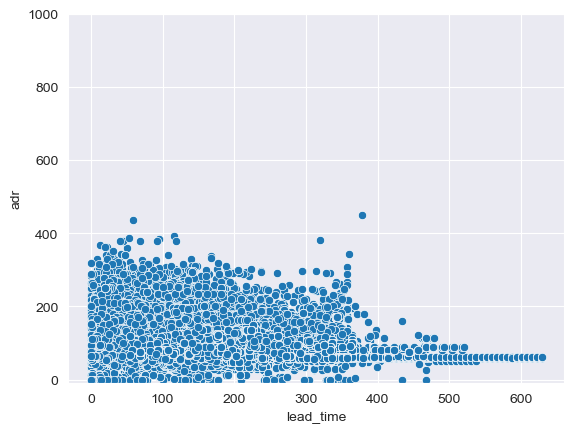

In [181]:
sb.scatterplot(data=data.query('is_canceled == 1'), y='adr', x='lead_time')

In [201]:
data.query('adr > adr.quantile(0.75) + 1.5*(adr.quantile(0.75) - adr.quantile(0.25))')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
140,Resort Hotel,0,44,2015,July,28,5,2,0,3,...,No Deposit,240.0,0.0,0,Transient,225.00,2,0,Check-Out,7/7/2015
303,Resort Hotel,0,79,2015,July,28,11,2,6,2,...,No Deposit,250.0,0.0,0,Transient,213.75,0,0,Check-Out,19/7/2015
396,Resort Hotel,0,317,2015,July,29,14,1,5,2,...,No Deposit,240.0,0.0,0,Transient,230.67,1,2,Check-Out,20/7/2015
412,Resort Hotel,0,37,2015,July,29,15,2,6,2,...,No Deposit,240.0,0.0,0,Transient,216.13,1,0,Check-Out,23/7/2015
523,Resort Hotel,0,0,2015,July,29,18,0,1,2,...,No Deposit,0.0,0.0,0,Transient,249.00,0,0,Check-Out,19/7/2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119251,City Hotel,0,140,2017,August,35,27,2,3,2,...,No Deposit,9.0,0.0,0,Transient,235.00,0,0,Check-Out,1/9/2017
119289,City Hotel,0,25,2017,August,35,30,0,3,3,...,No Deposit,9.0,0.0,0,Transient,236.33,0,3,Check-Out,2/9/2017
119339,City Hotel,0,110,2017,August,35,29,0,5,3,...,No Deposit,14.0,0.0,0,Transient,229.00,0,1,Check-Out,3/9/2017
119365,City Hotel,0,54,2017,August,35,27,3,5,1,...,No Deposit,14.0,0.0,0,Transient,266.75,0,1,Check-Out,4/9/2017


In [203]:
data.query('adr < 0')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
14969,Resort Hotel,0,195,2017,March,10,5,4,6,2,...,No Deposit,273.0,0.0,0,Transient-Party,-6.38,0,0,Check-Out,15/3/2017


In [204]:
data.query('adr < adr.quantile(0.25) - 1.5*(adr.quantile(0.75) - adr.quantile(0.25))')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date


In [214]:
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,74.828319,10.775157,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,107.141953,53.943884,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


# Variable Breakdown by Type
##### Numerical
* lead_time
* arrival_data_week_number [useful when looking for trends]
* {engineered} total_stay = sum(stays_in_weekend_nights, stays_in_week_nights)
    > * stays_in_weekend_nights
    > * stays_in_week_nights
* adults
* children
* babies
* {engineered} previous_bookings = sum(previous_cancellations, previous_bookings_not_canceled)
    > * previous_cancellations
    > * previous_bookings_not_canceled
* booking changes
* days_in_waiting_list
* adr
* required_car_parking_spaces
* total_of_special_requests
* {engineered} days_till_status_change = arrival_date - reservation_status_date
* boolean
    > * [target] is_canceled
    > * is_repeated_guest
    > * {engineered} assigned_room_preference: reserved_room_type == assigned_room_type

##### Date_Time
* {engineered} arrival_date = concat(year, month, day) [These 3 columns will be dropped after concatenation]
* reservation_status_date
##### Categorical
###### Nominal
* 'hotel'
* 'country'
* 'market_segment'
* 'distribution_channel'
* 'agent'
* 'company'
* 'customer_type',
###### Ordinal
* 'meal'
* 'reserved_room_type'
* 'assigned_room_type'
* 'deposit_type'
* [potential_target] reservation_status


In [313]:
# setting column types
numerical_data = data.copy()
numerical_data = numerical_data[['lead_time',
                                 'arrival_date_week_number',
                                 'stays_in_weekend_nights',
                                 'stays_in_week_nights',
                                 'adults',
                                 'children',
                                 'babies',
                                 'previous_cancellations',
                                 'previous_bookings_not_canceled',
                                 'booking_changes',
                                 'days_in_waiting_list',
                                 'adr',
                                 'required_car_parking_spaces',
                                 'total_of_special_requests',
                                 'is_repeated_guest',
                                 'is_canceled']]
numerical_data.head()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_repeated_guest,is_canceled
0,342,27,0,0,2,0.0,0,0,0,3,0,0.0,0,0,0,0
1,737,27,0,0,2,0.0,0,0,0,4,0,0.0,0,0,0,0
2,7,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0
3,13,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0
4,14,27,0,2,2,0.0,0,0,0,0,0,98.0,0,1,0,0


In [314]:
# viewing column info
numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       119390 non-null  int64  
 1   arrival_date_week_number        119390 non-null  int64  
 2   stays_in_weekend_nights         119390 non-null  int64  
 3   stays_in_week_nights            119390 non-null  int64  
 4   adults                          119390 non-null  int64  
 5   children                        119390 non-null  float64
 6   babies                          119390 non-null  int64  
 7   previous_cancellations          119390 non-null  int64  
 8   previous_bookings_not_canceled  119390 non-null  int64  
 9   booking_changes                 119390 non-null  int64  
 10  days_in_waiting_list            119390 non-null  int64  
 11  adr                             119390 non-null  float64
 12  required_car_par

In [315]:
# datetime_columns
datetime_data = data.copy()
datetime_data = datetime_data[['reservation_status_date', 'arrival_date_day_of_month', 'arrival_date_month', 'arrival_date_year']]
datetime_data.head()

,reservation_status_date,arrival_date_day_of_month,arrival_date_month,arrival_date_year
0,1/7/2015,1,July,2015
1,1/7/2015,1,July,2015
2,2/7/2015,1,July,2015
3,2/7/2015,1,July,2015
4,3/7/2015,1,July,2015


In [316]:
# Categorical data
numerical_cols = [_ for _ in numerical_data.columns]
datetime_data_cols = [_ for _ in datetime_data.columns]
non_cat_columns = numerical_cols + datetime_data_cols
len(non_cat_columns)

20

In [317]:
cat_cols = [_ for _ in data.columns if _ not in non_cat_columns]
cat_cols

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'agent',
 'company',
 'customer_type',
 'reservation_status']

In [318]:
cat_data = data.copy()
cat_data = cat_data[cat_cols]
cat_data.head()

,hotel,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,agent,company,customer_type,reservation_status
0,Resort Hotel,BB,PRT,Direct,Direct,C,C,No Deposit,0.0,0.0,Transient,Check-Out
1,Resort Hotel,BB,PRT,Direct,Direct,C,C,No Deposit,0.0,0.0,Transient,Check-Out
2,Resort Hotel,BB,GBR,Direct,Direct,A,C,No Deposit,0.0,0.0,Transient,Check-Out
3,Resort Hotel,BB,GBR,Corporate,Corporate,A,A,No Deposit,304.0,0.0,Transient,Check-Out
4,Resort Hotel,BB,GBR,Online TA,TA/TO,A,A,No Deposit,240.0,0.0,Transient,Check-Out


In [319]:
# deleting obsolete items
if cat_cols:
    del cat_cols
if numerical_cols:
    del numerical_cols
if datetime_data_cols:
    del datetime_data_cols
if non_cat_columns:
    del non_cat_columns

In [320]:
# check datatypes for categorical data
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   hotel                 119390 non-null  object 
 1   meal                  119390 non-null  object 
 2   country               119390 non-null  object 
 3   market_segment        119390 non-null  object 
 4   distribution_channel  119390 non-null  object 
 5   reserved_room_type    119390 non-null  object 
 6   assigned_room_type    119390 non-null  object 
 7   deposit_type          119390 non-null  object 
 8   agent                 119390 non-null  float64
 9   company               119390 non-null  float64
 10  customer_type         119390 non-null  object 
 11  reservation_status    119390 non-null  object 
dtypes: float64(2), object(10)
memory usage: 10.9+ MB


In [329]:
# let's convert all of these to category
cat_data = cat_data.astype('category')
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   hotel                 119390 non-null  category
 1   meal                  119390 non-null  category
 2   country               119390 non-null  category
 3   market_segment        119390 non-null  category
 4   distribution_channel  119390 non-null  category
 5   reserved_room_type    119390 non-null  category
 6   assigned_room_type    119390 non-null  category
 7   deposit_type          119390 non-null  category
 8   agent                 119390 non-null  category
 9   company               119390 non-null  category
 10  customer_type         119390 non-null  category
 11  reservation_status    119390 non-null  category
dtypes: category(12)
memory usage: 1.7 MB


In [673]:
# set orders to the ordinal data
ordinal_data = cat_data.copy()
ordinal_data = ordinal_data[['meal', 'reserved_room_type', 'assigned_room_type', 'deposit_type']]
# from the data dictionary, we know that sc and undefined mean no meal package for the customer, with undefined being used to avoid excessive labels
ordinal_data.meal = ordinal_data.meal.replace('Undefined', 'SC')
# let's re-level the data now
ordinal_data.meal = ordinal_data.meal.cat.reorder_categories(['SC', 'BB', 'HB', 'FB'], ordered = True)
ordinal_data.meal.unique()
# let's move onto room types
# Here we can make an assumption that the less common rooms would be the more premium ones
# to check this, we can count values after grouping
# our order is hence
grouped = ordinal_data.groupby('reserved_room_type').count().sort_values(by = 'meal', ascending=False).index
room_order = [_ for _ in grouped]
# re-level the data for reserved room types
ordinal_data.reserved_room_type = ordinal_data.reserved_room_type.cat.reorder_categories(room_order, ordered = True)
del grouped
del room_order
# repeat for assigned_room_type
grouped = ordinal_data.groupby('assigned_room_type').count().sort_values(by = 'meal', ascending=False).index
room_order = [_ for _ in grouped]
ordinal_data.assigned_room_type = ordinal_data.assigned_room_type.cat.reorder_categories(room_order, ordered = True)
del grouped
del room_order
# we can reorder deposit_type as is
ordinal_data.deposit_type = ordinal_data.deposit_type.cat.reorder_categories(['No Deposit', 'Refundable', 'Non Refund'], ordered = True)
ordinal_data.head()

,meal,reserved_room_type,assigned_room_type,deposit_type
0,BB,C,C,No Deposit
1,BB,C,C,No Deposit
2,BB,A,C,No Deposit
3,BB,A,A,No Deposit
4,BB,A,A,No Deposit


In [331]:
# print original levels for each category
for column in ordinal_data.columns:
    print(ordinal_data[f'{column}'].unique())

['BB', 'FB', 'HB', 'SC', 'Undefined']
Categories (5, object): ['BB', 'FB', 'HB', 'SC', 'Undefined']
['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B']
Categories (10, object): ['A', 'B', 'C', 'D', ..., 'G', 'H', 'L', 'P']
['C', 'A', 'D', 'E', 'G', ..., 'B', 'H', 'P', 'L', 'K']
Length: 12
Categories (12, object): ['A', 'B', 'C', 'D', ..., 'I', 'K', 'L', 'P']
['No Deposit', 'Refundable', 'Non Refund']
Categories (3, object): ['No Deposit', 'Non Refund', 'Refundable']


In [332]:
# from the data dictionary, we know that sc and undefined mean no meal package for the customer, with undefined being used to avoid excessive labels
ordinal_data.meal = ordinal_data.meal.replace('Undefined', 'SC')
# let's re-level the data now
ordinal_data.meal = ordinal_data.meal.cat.reorder_categories(['SC', 'BB', 'HB', 'FB'], ordered = True)
ordinal_data.meal.unique()

['BB', 'FB', 'HB', 'SC']
Categories (4, object): ['SC' < 'BB' < 'HB' < 'FB']

In [333]:
# let's move onto room types
# Here we can make an assumption that the less common rooms would be the more premium ones
# to check this, we can count values after grouping
# our order is hence
grouped = ordinal_data.groupby('reserved_room_type').count().sort_values(by = 'meal', ascending=False).index
room_order = [_ for _ in grouped]
# re-level the data for reserved room types
ordinal_data.reserved_room_type = ordinal_data.reserved_room_type.cat.reorder_categories(room_order, ordered = True)
del grouped
del room_order
ordinal_data.head()

,meal,reserved_room_type,assigned_room_type,deposit_type
0,BB,C,C,No Deposit
1,BB,C,C,No Deposit
2,BB,A,C,No Deposit
3,BB,A,A,No Deposit
4,BB,A,A,No Deposit


In [334]:
# repeat for assigned_room_type
grouped = ordinal_data.groupby('assigned_room_type').count().sort_values(by = 'meal', ascending=False).index
room_order = [_ for _ in grouped]
ordinal_data.assigned_room_type = ordinal_data.assigned_room_type.cat.reorder_categories(room_order, ordered = True)
del grouped
del room_order
ordinal_data.assigned_room_type.unique()

['C', 'A', 'D', 'E', 'G', ..., 'B', 'H', 'P', 'L', 'K']
Length: 12
Categories (12, object): ['A' < 'D' < 'E' < 'F' ... 'I' < 'K' < 'P' < 'L']

In [335]:
# we can reorder deposit_type as is
ordinal_data.deposit_type = ordinal_data.deposit_type.cat.reorder_categories(['No Deposit', 'Refundable', 'Non Refund'], ordered = True)
ordinal_data.deposit_type.unique()

['No Deposit', 'Refundable', 'Non Refund']
Categories (3, object): ['No Deposit' < 'Refundable' < 'Non Refund']

In [336]:
nominal_cat_data = cat_data.copy().drop(columns = ordinal_data.columns, axis=1)
nominal_cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   hotel                 119390 non-null  category
 1   country               119390 non-null  category
 2   market_segment        119390 non-null  category
 3   distribution_channel  119390 non-null  category
 4   agent                 119390 non-null  category
 5   company               119390 non-null  category
 6   customer_type         119390 non-null  category
 7   reservation_status    119390 non-null  category
dtypes: category(8)
memory usage: 1.3 MB


In [344]:
# let's see the number of categories in each column
x = 0
for column in ordinal_data.columns:
    tmp = [_ for _ in ordinal_data[f'{column}'].unique()]
    print(f'Column: {column}, Number of unique objects: {len(tmp)}')
    x += len(tmp)
print(f'Total number of categories: {x}')

Column: meal, Number of unique objects: 4
Column: reserved_room_type, Number of unique objects: 10
Column: assigned_room_type, Number of unique objects: 12
Column: deposit_type, Number of unique objects: 3
Total number of categories: 29


In [343]:
# let's see the number of categories in each column
x = 0
for column in nominal_cat_data.columns:
    tmp = [_ for _ in nominal_cat_data[f'{column}'].unique()]
    print(f'Column: {column}, Number of unique objects: {len(tmp)}')
    x += len(tmp)
print(f'Total number of categories: {x}')

Column: hotel, Number of unique objects: 2
Column: country, Number of unique objects: 177
Column: market_segment, Number of unique objects: 8
Column: distribution_channel, Number of unique objects: 5
Column: agent, Number of unique objects: 334
Column: company, Number of unique objects: 353
Column: customer_type, Number of unique objects: 4
Column: reservation_status, Number of unique objects: 3
Total number of categories: 886


In [346]:
# Check unique items in each column to ensure they are safe to use
for column in nominal_cat_data.columns:
    if column == 'country' or column == 'agent' or column == 'company':
        continue
    tmp = [_ for _ in nominal_cat_data[f'{column}'].unique()]
    print(tmp)

['Resort Hotel', 'City Hotel']
['Direct', 'Corporate', 'Online TA', 'Offline TA/TO', 'Complementary', 'Groups', 'Undefined', 'Aviation']
['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS']
['Transient', 'Contract', 'Transient-Party', 'Group']
['Check-Out', 'Canceled', 'No-Show']


In [354]:
nominal_cat_data.query('distribution_channel == "Undefined"')

,hotel,country,market_segment,distribution_channel,agent,company,customer_type,reservation_status
14594,Resort Hotel,PRT,Direct,Undefined,0.0,0.0,Transient,Check-Out
40600,City Hotel,PRT,Undefined,Undefined,0.0,0.0,Transient-Party,Canceled
40667,City Hotel,PRT,Direct,Undefined,14.0,0.0,Transient-Party,Canceled
40679,City Hotel,PRT,Undefined,Undefined,0.0,0.0,Transient-Party,Canceled
41160,City Hotel,PRT,Online TA,Undefined,9.0,0.0,Transient-Party,Canceled


In [355]:
nominal_cat_data.query('market_segment == "Undefined"')

,hotel,country,market_segment,distribution_channel,agent,company,customer_type,reservation_status
40600,City Hotel,PRT,Undefined,Undefined,0.0,0.0,Transient-Party,Canceled
40679,City Hotel,PRT,Undefined,Undefined,0.0,0.0,Transient-Party,Canceled


In [361]:
# since these are only a total of 5 records with undefined for market_segment, and distribution_channel, we can set them to the modal values
nominal_cat_data.groupby(['distribution_channel', 'market_segment']).count().sort_values(by = 'customer_type', ascending=False)

hotel  country  agent  company  \
distribution_channel market_segment                                   
TA/TO                Online TA       56153    56153  56153    56153   
                     Offline TA/TO   23946    23946  23946    23946   
                     Groups          17111    17111  17111    17111   
Direct               Direct          12276    12276  12276    12276   
Corporate            Corporate        4788     4788   4788     4788   
...                                    ...      ...    ...      ...   
Undefined            Corporate           0        0      0        0   
Corporate            Undefined           0        0      0        0   
Undefined            Groups              0        0      0        0   
                     Offline TA/TO       0        0      0        0   
GDS                  Groups              0        0      0        0   

                                     customer_type  reservation_status  
distribution_channel market_segment                                     
TA/TO                Online TA               56153               56153  
                     Offline TA/TO           23946               23946  
                     Groups                  17111               17111  
Direct               Direct                  12276               12276  
Corporate            Corporate                4788                4788  
...                                            ...                 ...  
Undefined            Corporate                   0                   0  
Corporate            Undefined                   0                   0  
Undefined            Groups                      0                   0  
                     Offline TA/TO               0                   0  
GDS                  Groups                      0                   0  

[40 rows x 6 columns]

In [362]:
# replace undefined with TA/TO and Online TA for dist chan and mark seg
nominal_cat_data.distribution_channel = nominal_cat_data.distribution_channel.replace('Undefined', 'TA/TO')
nominal_cat_data.market_segment = nominal_cat_data.market_segment.replace('Undefined', 'Online TA')
nominal_cat_data.head()

,hotel,country,market_segment,distribution_channel,agent,company,customer_type,reservation_status
0,Resort Hotel,PRT,Direct,Direct,0.0,0.0,Transient,Check-Out
1,Resort Hotel,PRT,Direct,Direct,0.0,0.0,Transient,Check-Out
2,Resort Hotel,GBR,Direct,Direct,0.0,0.0,Transient,Check-Out
3,Resort Hotel,GBR,Corporate,Corporate,304.0,0.0,Transient,Check-Out
4,Resort Hotel,GBR,Online TA,TA/TO,240.0,0.0,Transient,Check-Out


# Encoding Categorical Variables

In [ ]:
# Ordinal Data Encoding Using Label Encoding

In [370]:
# Merge the two to return a combined categorical variable dataset for encoding
cat_data_final = pd.concat([ordinal_data.copy(), nominal_cat_data.copy()], axis=1)
cat_data_final.head()

,meal,reserved_room_type,assigned_room_type,deposit_type,hotel,country,market_segment,distribution_channel,agent,company,customer_type,reservation_status
0,BB,C,C,No Deposit,Resort Hotel,PRT,Direct,Direct,0.0,0.0,Transient,Check-Out
1,BB,C,C,No Deposit,Resort Hotel,PRT,Direct,Direct,0.0,0.0,Transient,Check-Out
2,BB,A,C,No Deposit,Resort Hotel,GBR,Direct,Direct,0.0,0.0,Transient,Check-Out
3,BB,A,A,No Deposit,Resort Hotel,GBR,Corporate,Corporate,304.0,0.0,Transient,Check-Out
4,BB,A,A,No Deposit,Resort Hotel,GBR,Online TA,TA/TO,240.0,0.0,Transient,Check-Out


In [419]:
# Performing encoding depending on number of categories
def cat_encoding(data_frame:pd.DataFrame, target: 'str' = 'is_canceled'):
    """
    Performs encoding on categorical data using different encoders depending on the number of categories
        > LeaveOneOutEncoding if the data has size less than equal to 100
        > CatBoostEncoding otherwise
    :param data_frame: The input dataframe with categorical data
    :param target: The target column for target-based encoders
    :return: A copy of the original dataframe with the encoded data
    """
    df = data_frame.copy()
    categorical_cols = df.select_dtypes(include=['category']).columns
    if len(categorical_cols) > 0:
        # Label encoding for ordinal categories
        for col in categorical_cols:
            if len(df[col].unique()) <= 100:
                # Target encoding for high cardinality categories
                loo = LeaveOneOutEncoder(sigma=0.3, random_state=2407)
                df[col] = loo.fit_transform(df[col], df[f'{target}'])
            else:
                # Target encoding for very high cardinality categories
                cb = CatBoostEncoder(sigma=0.5, random_state=2407)
                df[col] = cb.fit_transform(df[col], df[f'{target}'])
    return df

In [417]:
ordinal_data['is_canceled'] = data['is_canceled'].copy()
ordinal_data_encoded = cat_encoding(ordinal_data)
ordinal_data_encoded.head()

,meal,reserved_room_type,assigned_room_type,deposit_type,is_canceled
0,0.370689,0.328027,0.186279,0.281371,0
1,0.508977,0.450400,0.255771,0.386338,0
2,0.258566,0.270479,0.129934,0.196264,0
3,0.396356,0.414618,0.471712,0.300854,0
4,0.430503,0.450338,0.512351,0.326773,0


In [418]:
nominal_cat_data['is_canceled'] = data['is_canceled'].copy()
nominal_data_encoded = cat_encoding(nominal_cat_data)
nominal_data_encoded.head()

,hotel,country,market_segment,distribution_channel,agent,company,customer_type,reservation_status,is_canceled
0,0.275291,0.365191,0.152133,0.173133,0.365191,0.365191,0.404019,0.0,0
1,0.377989,0.296776,0.208887,0.237721,0.296776,0.296776,0.554741,0.0,0
2,0.192023,0.180037,0.106117,0.120765,0.060012,0.060012,0.281814,0.0,0
3,0.294352,0.203788,0.198661,0.234081,0.407577,0.101894,0.431994,0.0,0
4,0.319711,0.154655,0.422888,0.472452,0.463965,0.092793,0.469211,0.0,0


In [475]:
# Merge categorical variables into single column
cat_data_final = pd.concat([nominal_data_encoded.copy().drop('is_canceled', axis=1), ordinal_data_encoded.copy().drop('is_canceled', axis=1)], axis=1)
cat_data_final.head()

,hotel,country,market_segment,distribution_channel,agent,company,customer_type,reservation_status,meal,reserved_room_type,assigned_room_type,deposit_type
0,0.275291,0.365191,0.152133,0.173133,0.365191,0.365191,0.404019,0.0,0.370689,0.328027,0.186279,0.281371
1,0.377989,0.296776,0.208887,0.237721,0.296776,0.296776,0.554741,0.0,0.508977,0.450400,0.255771,0.386338
2,0.192023,0.180037,0.106117,0.120765,0.060012,0.060012,0.281814,0.0,0.258566,0.270479,0.129934,0.196264
3,0.294352,0.203788,0.198661,0.234081,0.407577,0.101894,0.431994,0.0,0.396356,0.414618,0.471712,0.300854
4,0.319711,0.154655,0.422888,0.472452,0.463965,0.092793,0.469211,0.0,0.430503,0.450338,0.512351,0.326773


# Cleaning Numerical Data

In [546]:
def data_stat_finder(df: pd.DataFrame, target: str='is_canceled'):
    # we first go through the value counts for the individual columns
    results = []
    for i in df.columns:
        curr = df[i]
        mean = curr.mean()
        median = curr.median()
        third_quartile = curr.quantile(0.75)
        variance = curr.var()
        sd = np.sqrt(variance)
        covariance_with_target = curr.cov(data[f'{target}'])
        skew = curr.skew()
        kurtosis = curr.kurt()
        results.append([i, mean, median, third_quartile, variance, sd, covariance_with_target, skew, kurtosis, ])
    data_stats = pd.DataFrame(results, columns = ['col_name', 'mean', 'median', 'third_quartile', 'variance', 'sd', 'covariance_with_target', 'skew', 'kurtosis'] )
    return data_stats

In [547]:
data_stats = data_stat_finder(numerical_data)
data_stats

,col_name,mean,median,third_quartile,variance,sd,covariance_with_target,skew,kurtosis
0,lead_time,104.011416,69.000,160.0,11419.721511,106.863097,15.126964,1.346550,1.696449
1,arrival_date_week_number,27.165173,28.000,38.0,185.099790,13.605138,0.053534,-0.010014,-0.986077
2,stays_in_weekend_nights,0.927599,1.000,2.0,0.997229,0.998613,-0.000864,1.380046,7.174066
3,stays_in_week_nights,2.500302,2.000,3.0,3.641554,1.908286,0.022822,2.862249,24.284555
4,adults,1.856403,2.000,2.0,0.335543,0.579261,0.016789,18.317805,1352.115116
5,children,0.103886,0.000,0.0,0.158846,0.398555,0.000969,4.112670,18.674464
6,babies,0.007949,0.000,0.0,0.009494,0.097436,-0.001529,24.646545,1633.948235
7,previous_cancellations,0.087118,0.000,0.0,0.712904,0.844336,0.044906,24.458049,674.073693
8,previous_bookings_not_canceled,0.137097,0.000,0.0,2.242317,1.497437,-0.041478,23.539800,767.245210
9,booking_changes,0.221124,0.000,0.0,0.425503,0.652306,-0.045481,6.000270,79.393605


In [540]:
# Defining a function to address outliers
from scipy.stats import mstats
def numerical_cleaning(data_frame: pd.DataFrame, target: str='is_canceled'):
    df = data_frame.copy().drop(f'{target}', axis=1)
    col_list = df.select_dtypes(include=['int', 'float']).columns
    # outlier winsorization of 10 percent of data from upper and lower limits
    for col in col_list:
        df[f'{col}'] = pd.DataFrame(mstats.winsorize(df[f'{col}'], limits=[0.1,0.1]))
    """# skewness and kurtosis management
    # skewness > 1 and kurtosis > 3 will be transformed
    skewness = df[col_list].skew()
    skewed_cols = skewness[abs(skewness) > 0.5].index
    if len(skewed_cols) > 0:
        df[skewed_cols] = df[skewed_cols].apply(lambda x: np.log1p(x))"""
    df[f'{target}'] = data_frame.copy()[f'{target}']
    return df

In [541]:
num_data_2 = numerical_cleaning(numerical_data)
num_data_2.head()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_repeated_guest,is_canceled
0,265,27,0,1,2,0.0,0,0,0,1,0,50.0,0,0,0,0
1,265,27,0,1,2,0.0,0,0,0,1,0,50.0,0,0,0,0
2,7,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0
3,13,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0
4,14,27,0,2,2,0.0,0,0,0,0,0,98.0,0,1,0,0


In [542]:
num_data_2.describe()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_repeated_guest,is_canceled
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.0,119390.0,119390.0,119390.0,119390.000000,119390.0,119390.000000,119390.0,119390.000000,119390.0,119390.000000
mean,96.594028,27.130497,0.872418,2.429006,1.803752,0.0,0.0,0.0,0.0,0.151403,0.0,99.571503,0.0,0.543747,0.0,0.370416
std,88.065356,12.547200,0.852765,1.357040,0.397160,0.0,0.0,0.0,0.0,0.358443,0.0,35.992074,0.0,0.716617,0.0,0.482918
min,3.000000,8.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,50.000000,0.0,0.000000,0.0,0.000000
25%,18.000000,16.000000,0.000000,1.000000,2.000000,0.0,0.0,0.0,0.0,0.000000,0.0,69.290000,0.0,0.000000,0.0,0.000000
50%,69.000000,28.000000,1.000000,2.000000,2.000000,0.0,0.0,0.0,0.0,0.000000,0.0,94.575000,0.0,0.000000,0.0,0.000000
75%,160.000000,38.000000,2.000000,3.000000,2.000000,0.0,0.0,0.0,0.0,0.000000,0.0,126.000000,0.0,1.000000,0.0,1.000000
max,265.000000,46.000000,2.000000,5.000000,2.000000,0.0,0.0,0.0,0.0,1.000000,0.0,164.000000,0.0,2.000000,0.0,1.000000


In [543]:
# multicollinearity checking
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_data.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_data.values, i)
                   for i in range(len(numerical_data.columns))]

print(vif_data)

                           feature       VIF
0                        lead_time  2.375091
1         arrival_date_week_number  4.280514
2          stays_in_weekend_nights  2.502810
3             stays_in_week_nights  3.643989
4                           adults  7.753374
5                         children  1.198333
6                           babies  1.023903
7           previous_cancellations  1.061239
8   previous_bookings_not_canceled  1.248645
9                  booking_changes  1.156812
10            days_in_waiting_list  1.057273
11                             adr  5.853116
12     required_car_parking_spaces  1.124373
13       total_of_special_requests  1.718637
14               is_repeated_guest  1.261591
15                     is_canceled  1.919457


In [551]:
data_stat_finder(numerical_data).head()

,col_name,mean,median,third_quartile,variance,sd,covariance_with_target,skew,kurtosis
0,lead_time,104.011416,69.0,160.0,11419.721511,106.863097,15.126964,1.346550,1.696449
1,arrival_date_week_number,27.165173,28.0,38.0,185.099790,13.605138,0.053534,-0.010014,-0.986077
2,stays_in_weekend_nights,0.927599,1.0,2.0,0.997229,0.998613,-0.000864,1.380046,7.174066
3,stays_in_week_nights,2.500302,2.0,3.0,3.641554,1.908286,0.022822,2.862249,24.284555
4,adults,1.856403,2.0,2.0,0.335543,0.579261,0.016789,18.317805,1352.115116


In [544]:
# We see that adults and adr are highly correlated. This fits with the hotel pricing model where more adults per room increases rate of that room
# Currently, we don't wish to change these values

* {engineered} total_stay = sum(stays_in_weekend_nights, stays_in_week_nights)
* {engineered} days_till_status_change = arrival_date - reservation_status_date

In [578]:
# Total Stay
numerical_data['total_nights_stayed'] = numerical_data.stays_in_week_nights.copy()
numerical_data['total_nights_stayed'] += numerical_data.stays_in_weekend_nights
numerical_data.head()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_repeated_guest,is_canceled,total_nights_stayed
0,342,27,0,0,2,0.0,0,0,0,3,0,0.0,0,0,0,0,0
1,737,27,0,0,2,0.0,0,0,0,4,0,0.0,0,0,0,0,0
2,7,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0,1
3,13,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0,1
4,14,27,0,2,2,0.0,0,0,0,0,0,98.0,0,1,0,0,2


In [579]:
# Days till status_change
year_format = lambda year, month, day: str(f'{day}/{month}/{year}')
datetime_data.loc[:,'arrival_date'] = datetime_data.apply(lambda x: year_format(x['arrival_date_year'], x['arrival_date_month'],
                                                                        x['arrival_date_day_of_month']), axis=1)
datetime_data.head()

,reservation_status_date,arrival_date_day_of_month,arrival_date_month,arrival_date_year,arrival_date
0,1/7/2015,1,July,2015,1/July/2015
1,1/7/2015,1,July,2015,1/July/2015
2,2/7/2015,1,July,2015,1/July/2015
3,2/7/2015,1,July,2015,1/July/2015
4,3/7/2015,1,July,2015,1/July/2015


In [582]:
datetime_data.reservation_status_date = pd.to_datetime(datetime_data.reservation_status_date, format="%d/%m/%Y")
datetime_data.arrival_date = pd.to_datetime(datetime_data.reservation_status_date, format="%d/%m/%Y")
datetime_data.head()

,reservation_status_date,arrival_date_day_of_month,arrival_date_month,arrival_date_year,arrival_date
0,2015-01-07,1,July,2015,2015-01-07
1,2015-01-07,1,July,2015,2015-01-07
2,2015-02-07,1,July,2015,2015-02-07
3,2015-02-07,1,July,2015,2015-02-07
4,2015-03-07,1,July,2015,2015-03-07


In [588]:
datetime_data['days_till_status_change'] = (datetime_data.reservation_status_date - datetime_data.arrival_date)
datetime_data.head()

,reservation_status_date,arrival_date_day_of_month,arrival_date_month,arrival_date_year,arrival_date,days_till_status_change
0,2015-01-07,1,July,2015,2015-01-07,0 days
1,2015-01-07,1,July,2015,2015-01-07,0 days
2,2015-02-07,1,July,2015,2015-02-07,0 days
3,2015-02-07,1,July,2015,2015-02-07,0 days
4,2015-03-07,1,July,2015,2015-03-07,0 days


In [590]:
numerical_data['days_to_status_change'] = pd.to_numeric(datetime_data.days_till_status_change, errors='raise')
numerical_data.head()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_repeated_guest,is_canceled,total_nights_stayed,days_to_status_change
0,342,27,0,0,2,0.0,0,0,0,3,0,0.0,0,0,0,0,0,0
1,737,27,0,0,2,0.0,0,0,0,4,0,0.0,0,0,0,0,0,0
2,7,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0,1,0
3,13,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0,1,0
4,14,27,0,2,2,0.0,0,0,0,0,0,98.0,0,1,0,0,2,0


In [591]:
# number of guests
# Total Stay
numerical_data['total_guests'] = numerical_data.adults.copy()
numerical_data['total_guests'] += numerical_data.children + numerical_data.babies
numerical_data.head()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_repeated_guest,is_canceled,total_nights_stayed,days_to_status_change,total_guests
0,342,27,0,0,2,0.0,0,0,0,3,0,0.0,0,0,0,0,0,0,2.0
1,737,27,0,0,2,0.0,0,0,0,4,0,0.0,0,0,0,0,0,0,2.0
2,7,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0,1,0,1.0
3,13,27,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0,1,0,1.0
4,14,27,0,2,2,0.0,0,0,0,0,0,98.0,0,1,0,0,2,0,2.0


In [623]:
scaler = StandardScaler()
standardized_num_data = pd.DataFrame(scaler.fit_transform(numerical_data.drop('is_canceled', axis=1)))
standardized_num_data.columns = numerical_data.drop('is_canceled', axis=1).columns

In [624]:
standardized_cat_data = pd.DataFrame(scaler.fit_transform(cat_data_final))
standardized_cat_data.columns = cat_data_final.columns

In [625]:
from sklearn.preprocessing import RobustScaler
r_scaler = RobustScaler()
robust_standardized_num_data = pd.DataFrame(r_scaler.fit_transform(numerical_data.drop('is_canceled', axis=1)))
robust_standardized_num_data.columns = numerical_data.drop('is_canceled', axis=1).columns

In [626]:
robust_standardized_cat_data = pd.DataFrame(r_scaler.fit_transform(cat_data_final))
robust_standardized_cat_data.columns = cat_data_final.columns

In [627]:
combined_standard = pd.concat([standardized_num_data.copy(), standardized_cat_data.copy(), data.is_canceled.copy()], axis = 1)
combined_robust = pd.concat([robust_standardized_num_data.copy(), robust_standardized_cat_data.copy(), data.is_canceled.copy()], axis = 1)

In [630]:
combined_robust.to_parquet('combined_robust.parquet.gzip', index=False, compression='gzip')
combined_standard.to_parquet('combined_standard.parquet.gzip', index=False, compression='gzip')

# Tranforming and Scaling the Data

In [606]:
boxcox(numerical_data['lead_time'])

ValueError: Data must be positive.

# Clustering for feature engineering (future task)

In [552]:
combined_data = pd.concat([cat_data_final, numerical_data], axis=1)
combined_data.head()

,hotel,country,market_segment,distribution_channel,agent,company,customer_type,reservation_status,meal,reserved_room_type,...,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_repeated_guest,is_canceled
0,0.275291,0.365191,0.152133,0.173133,0.365191,0.365191,0.404019,0.0,0.370689,0.328027,...,0,0,0,3,0,0.0,0,0,0,0
1,0.377989,0.296776,0.208887,0.237721,0.296776,0.296776,0.554741,0.0,0.508977,0.450400,...,0,0,0,4,0,0.0,0,0,0,0
2,0.192023,0.180037,0.106117,0.120765,0.060012,0.060012,0.281814,0.0,0.258566,0.270479,...,0,0,0,0,0,75.0,0,0,0,0
3,0.294352,0.203788,0.198661,0.234081,0.407577,0.101894,0.431994,0.0,0.396356,0.414618,...,0,0,0,0,0,75.0,0,0,0,0
4,0.319711,0.154655,0.422888,0.472452,0.463965,0.092793,0.469211,0.0,0.430503,0.450338,...,0,0,0,0,0,98.0,0,1,0,0


In [566]:
from sklearn.cluster import KMeans
# select columns you want to cluster
# initialize k-means with 5 clusters
kmeans = KMeans(n_clusters=5)
# fit k-means
kmeans.fit(combined_data)
# add cluster labels to DataFrame
combined_data['cluster_label'] = kmeans.labels_

In [570]:
combined_data.query('cluster_label == 3')

,hotel,country,market_segment,distribution_channel,agent,company,customer_type,reservation_status,meal,reserved_room_type,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_repeated_guest,is_canceled,cluster_label
85,0.216693,0.019574,0.267841,0.320217,0.217256,0.144511,0.241709,0.000000,0.268974,0.228625,...,0,0,0,0,134.73,0,0,0,0,3
182,0.355918,0.027224,0.439929,0.525957,0.544474,0.309894,0.397008,0.000000,0.479257,0.501339,...,0,0,0,0,47.25,0,0,0,0,3
208,0.217200,0.241094,0.268460,0.320988,0.118032,0.129820,0.242105,0.782377,0.292486,0.305962,...,0,0,0,0,47.25,0,0,0,1,3
223,0.226561,0.274954,0.280029,0.334821,0.095037,0.146170,0.252539,0.816095,0.281192,0.259323,...,0,0,0,0,112.00,0,1,0,1,3
246,0.134882,0.058911,0.178411,0.199321,0.040595,0.030824,0.197954,0.000000,0.167425,0.189992,...,0,0,0,0,112.00,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119370,0.459110,0.195297,0.404059,0.451417,0.484487,0.446143,0.448320,0.000000,0.411335,0.430287,...,0,0,0,0,108.00,0,2,0,0,3
119374,0.298702,0.088073,0.262885,0.293696,0.218512,0.201218,0.291681,0.000000,0.267619,0.279949,...,0,0,0,0,117.00,0,2,0,0,3
119375,0.500274,0.243059,0.411434,0.491891,0.104845,0.508971,0.488516,0.000000,0.448215,0.468867,...,0,0,0,0,85.50,0,1,0,0,3
119378,0.372672,0.166265,0.306492,0.366427,0.114943,0.314143,0.363913,0.000000,0.333891,0.349275,...,0,0,0,0,86.85,0,0,0,0,3


In [631]:
combined_robust.describe()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,distribution_channel,agent,company,customer_type,reservation_status,meal,reserved_room_type,assigned_room_type,deposit_type,is_canceled
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,...,1.193900e+05,119390.000000,1.193900e+05,119390.000000,119390.000000,1.193900e+05,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.246559,-0.037947,-0.036201,0.250151,-0.143597,0.103886,0.007949,0.087118,0.137097,0.221124,...,-2.753997e-02,0.148172,6.549396e-02,0.023607,0.427509,3.360466e-03,0.013869,0.066385,0.526561,0.370416
std,0.752557,0.618415,0.499307,0.954143,0.579261,0.398555,0.097436,0.844336,1.497437,0.652306,...,6.695404e-01,0.750319,7.774273e-01,0.702588,0.595559,7.541559e-01,0.739246,0.676230,1.956058,0.482918
min,-0.485915,-1.227273,-0.500000,-1.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.579695e+00,-3.192729,-3.226109e+00,-2.889991,-0.485003,-3.506930e+00,-3.170891,-2.152783,-4.214597,0.000000
25%,-0.359155,-0.545455,-0.500000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-5.443722e-01,-0.418164,-4.726154e-01,-0.487291,0.000000,-5.020385e-01,-0.493863,-0.449619,-0.462002,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.302906e-16,0.000000,8.137954e-17,0.000000,0.000000,1.844058e-16,0.000000,0.000000,0.000000,0.000000
75%,0.640845,0.454545,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.556278e-01,0.581836,5.273846e-01,0.512709,1.000000,4.979615e-01,0.506137,0.550381,0.537998,1.000000
max,4.704225,1.136364,9.000000,24.000000,53.000000,10.000000,10.000000,26.000000,72.000000,21.000000,...,2.569583e+00,4.529075,5.649720e+00,2.911332,2.518735,5.044171e+00,6.557916,4.714733,13.702167,1.000000


In [637]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
lr = LogisticRegression(max_iter=10000, penalty='elasticnet', solver='saga', l1_ratio=0.3)
X_train, X_test, y_train, y_test = train_test_split(combined_robust.drop('is_canceled',axis=1), combined_robust.is_canceled, test_size=0.35)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26256
           1       1.00      1.00      1.00     15531

    accuracy                           1.00     41787
   macro avg       1.00      1.00      1.00     41787
weighted avg       1.00      1.00      1.00     41787



In [639]:
combined_data.to_parquet('combined_data_basic.parquet.gzip', compression='gzip', index=False)

In [644]:
for col in ordinal_data.columns:
    ordinal_data[f'{col}'] = lab_e.fit_transform(ordinal_data[f'{col}'])

ordinal_data.head()

,meal,reserved_room_type,assigned_room_type,deposit_type,is_canceled
0,0,2,2,0,0
1,0,2,2,0,0
2,0,0,2,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [659]:
nominal_cat_data = nominal_cat_data.drop(['is_canceled'], axis=1)

KeyError: "['is_canceled'] not found in axis"

In [660]:
nominal_cat_data = nominal_cat_data.drop(['reservation_status'], axis=1)

In [661]:
from category_encoders import BinaryEncoder
bin_encoder = BinaryEncoder(nominal_cat_data.columns)
nominal_cat_data_bin_encoded = bin_encoder.fit_transform(nominal_cat_data.copy())
nominal_cat_data_bin_encoded.head()

,hotel_0,hotel_1,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,...,company_2,company_3,company_4,company_5,company_6,company_7,company_8,customer_type_0,customer_type_1,customer_type_2
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [662]:
ordinal_data = ordinal_data.drop('is_canceled', axis=1)

KeyError: "['is_canceled'] not found in axis"

In [663]:
encoded_data_v2 = pd.concat([numerical_data, ordinal_data, nominal_cat_data_bin_encoded], axis=1)
encoded_data_v2.to_parquet('encoded_data_v2.parquet.gzip', compression='gzip', index=False)

# DO ASSOCIATION RULES ON CAT DATA BEFORE ENCODING FML
# TODO: Association Rules for clustering categorical and boolean data

In [677]:
# dummy encoding the categorical data
cat_combined_for_assoc_rules = pd.concat([nominal_cat_data, ordinal_data], axis=1)
cat_combined_for_assoc_rules.head()

,hotel,country,market_segment,distribution_channel,agent,company,customer_type,meal,reserved_room_type,assigned_room_type,deposit_type
0,Resort Hotel,PRT,Direct,Direct,0.0,0.0,Transient,BB,C,C,No Deposit
1,Resort Hotel,PRT,Direct,Direct,0.0,0.0,Transient,BB,C,C,No Deposit
2,Resort Hotel,GBR,Direct,Direct,0.0,0.0,Transient,BB,A,C,No Deposit
3,Resort Hotel,GBR,Corporate,Corporate,304.0,0.0,Transient,BB,A,A,No Deposit
4,Resort Hotel,GBR,Online TA,TA/TO,240.0,0.0,Transient,BB,A,A,No Deposit


In [679]:
one_hot_cat = pd.get_dummies(cat_combined_for_assoc_rules)
one_hot_cat['is_canceled'] = data.is_canceled.copy()
one_hot_cat = one_hot_cat.applymap(bool)

In [684]:
# Association rules
from mlxtend.frequent_patterns import apriori, association_rules
# find frequent itemsets
frequent_itemsets = apriori(one_hot_cat, min_support=0.01, use_colnames=True)
# generate association rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
# display top 10 rules
rules.sort_values(by='lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
202245,"(market_segment_Online TA, assigned_room_type_...","(distribution_channel_TA/TO, reserved_room_typ...",0.010931,0.012522,0.010018,0.916475,73.189272,0.009881,11.822558
202254,"(distribution_channel_TA/TO, reserved_room_typ...","(market_segment_Online TA, assigned_room_type_...",0.012522,0.010931,0.010018,0.800000,73.189272,0.009881,4.945347
434450,"(market_segment_Online TA, deposit_type_No Dep...","(distribution_channel_TA/TO, reserved_room_typ...",0.010922,0.012522,0.010009,0.916411,73.184157,0.009872,11.813498
434485,"(distribution_channel_TA/TO, reserved_room_typ...","(market_segment_Online TA, deposit_type_No Dep...",0.012522,0.010922,0.010009,0.799331,73.184157,0.009872,4.928904
434465,"(distribution_channel_TA/TO, reserved_room_typ...","(market_segment_Online TA, assigned_room_type_...",0.012514,0.010931,0.010009,0.799866,73.177025,0.009872,4.942039
434473,"(market_segment_Online TA, assigned_room_type_...","(distribution_channel_TA/TO, reserved_room_typ...",0.010931,0.012514,0.010009,0.915709,73.177025,0.009872,11.715179
66236,"(distribution_channel_TA/TO, reserved_room_typ...","(market_segment_Online TA, assigned_room_type_...",0.012530,0.010931,0.010018,0.799465,73.140349,0.009881,4.932160
202262,"(distribution_channel_TA/TO, reserved_room_typ...","(market_segment_Online TA, company_0.0, assign...",0.012530,0.010931,0.010018,0.799465,73.140349,0.009881,4.932160
66226,"(market_segment_Online TA, assigned_room_type_...","(distribution_channel_TA/TO, reserved_room_typ...",0.010931,0.012530,0.010018,0.916475,73.140349,0.009881,11.822458
202235,"(market_segment_Online TA, company_0.0, assign...","(distribution_channel_TA/TO, reserved_room_typ...",0.010931,0.012530,0.010018,0.916475,73.140349,0.009881,11.822458


In [823]:
filtered_rules = rules[rules['consequents'].apply(lambda x: str(x) == "frozenset({'is_canceled'})")]
filtered_rules.sort_values(by = 'lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1020110,"(assigned_room_type_A, country_PRT, distributi...",(is_canceled),0.021878,0.370416,0.021878,1.000000,2.699665,0.013774,inf
184818,"(meal_BB, hotel_City Hotel, deposit_type_Non R...",(is_canceled),0.030924,0.370416,0.030924,1.000000,2.699665,0.019469,inf
190013,"(meal_HB, assigned_room_type_A, hotel_City Hot...",(is_canceled),0.010001,0.370416,0.010001,1.000000,2.699665,0.006296,inf
189997,"(meal_HB, hotel_City Hotel, deposit_type_Non R...",(is_canceled),0.010001,0.370416,0.010001,1.000000,2.699665,0.006296,inf
583962,"(assigned_room_type_A, country_PRT, hotel_City...",(is_canceled),0.033026,0.370416,0.033026,1.000000,2.699665,0.020793,inf
...,...,...,...,...,...,...,...,...,...
590019,"(market_segment_Offline TA/TO, country_PRT, di...",(is_canceled),0.028294,0.370416,0.014155,0.500296,1.350632,0.003675,1.259913
87706,"(country_PRT, distribution_channel_TA/TO, cust...",(is_canceled),0.039275,0.370416,0.019642,0.500107,1.350121,0.005094,1.259436
195773,"(country_PRT, distribution_channel_TA/TO, hote...",(is_canceled),0.039275,0.370416,0.019642,0.500107,1.350121,0.005094,1.259436
736079,"(market_segment_Offline TA/TO, assigned_room_t...",(is_canceled),0.040355,0.370416,0.020178,0.500000,1.349833,0.005229,1.259167


In [734]:
filtered_rules_df = pd.DataFrame(filtered_rules.copy())

In [814]:
import csv
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(filtered_rules.columns)
    writer.writerows(filtered_rules.values)

In [793]:
filtered_rules_df.to_csv('filtered_rules.csv', line_terminator='', index=False)

TypeError: __init__() got an unexpected keyword argument 'line_terminator'

In [822]:
str(filtered_rules.consequents.iloc[0])

"frozenset({'is_canceled'})"

In [825]:
one_hot_cat_v2 = pd.get_dummies(cat_combined_for_assoc_rules.drop(columns=['country', 'agent', 'company']))
one_hot_cat_v2['is_canceled'] = data.is_canceled.copy()
one_hot_cat_v2 = one_hot_cat_v2.applymap(bool)

In [829]:
frequent_itemsets_v2 = apriori(one_hot_cat_v2, min_support=0.01, use_colnames=True)

In [830]:
rules_v2 = association_rules(frequent_itemsets_v2, metric='confidence', min_threshold=0.5)
rules_v2 = rules_v2[rules_v2['consequents'].apply(lambda x: str(x) == "frozenset({'is_canceled'})")]
rules_v2.sort_values(by='lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21105,"(distribution_channel_TA/TO, assigned_room_typ...",(is_canceled),0.098978,0.370416,0.098978,1.0,2.699665,0.062315,inf
30216,"(assigned_room_type_A, meal_BB, hotel_City Hot...",(is_canceled),0.087579,0.370416,0.087579,1.0,2.699665,0.055138,inf
23965,"(assigned_room_type_A, hotel_City Hotel, depos...",(is_canceled),0.054335,0.370416,0.054335,1.0,2.699665,0.034208,inf
24569,"(market_segment_Offline TA/TO, distribution_ch...",(is_canceled),0.037130,0.370416,0.037130,1.0,2.699665,0.023377,inf
25225,"(market_segment_Offline TA/TO, meal_BB, hotel_...",(is_canceled),0.034358,0.370416,0.034358,1.0,2.699665,0.021631,inf
25292,"(market_segment_Offline TA/TO, hotel_City Hote...",(is_canceled),0.037038,0.370416,0.037038,1.0,2.699665,0.023319,inf
25315,"(market_segment_Offline TA/TO, assigned_room_t...",(is_canceled),0.036938,0.370416,0.036938,1.0,2.699665,0.023255,inf
28730,"(distribution_channel_TA/TO, meal_BB, hotel_Ci...",(is_canceled),0.085116,0.370416,0.085116,1.0,2.699665,0.053588,inf
28877,"(distribution_channel_TA/TO, hotel_City Hotel,...",(is_canceled),0.090996,0.370416,0.090996,1.0,2.699665,0.057290,inf
29037,"(assigned_room_type_A, distribution_channel_TA...",(is_canceled),0.090753,0.370416,0.090753,1.0,2.699665,0.057137,inf


In [832]:
import csv
with open('output_v2.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(rules_v2.columns)
    writer.writerows(rules_v2.values)

In [847]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2)
encoded_data_v3 = pf.fit_transform(encoded_data_v2.drop(columns='is_canceled'))

In [848]:
encoded_data_v3 = pd.DataFrame(encoded_data_v3)
encoded_data_v3.columns = pf.get_feature_names_out()
encoded_data_v3['is_canceled'] = data.is_canceled.copy()
encoded_data_v3.head()


,1,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,...,company_8 customer_type_0,company_8 customer_type_1,company_8 customer_type_2,customer_type_0^2,customer_type_0 customer_type_1,customer_type_0 customer_type_2,customer_type_1^2,customer_type_1 customer_type_2,customer_type_2^2,is_canceled
0,1.0,342.0,27.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,1.0,737.0,27.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,1.0,7.0,27.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,1.0,13.0,27.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,1.0,14.0,27.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [850]:
encoded_data_v3.to_parquet('encoded_data_v3.parquet.gzip', index=False, compression='gzip')

In [897]:
fi = FastICA(n_components=25, max_iter=500, tol=0.0005)
ica_data = fi.fit_transform(combined_data.copy().drop(columns=['is_canceled', 'reservation_status']))
ica_data

array([[ 6.09114853e-03,  9.81661864e-04,  1.73854444e-03, ...,
        -5.02679416e-03,  7.25147926e-04, -1.22474700e-04],
       [ 1.13794199e-02,  9.32361695e-04, -2.64211130e-03, ...,
        -6.22423432e-03,  6.68908903e-04, -3.84592579e-03],
       [ 5.00474207e-03,  8.24106797e-04,  4.30750276e-03, ...,
        -2.23298151e-03,  7.43383978e-04, -1.72928685e-03],
       ...,
       [ 2.44137465e-03,  1.09408220e-03, -5.92825141e-03, ...,
         8.89326296e-04,  6.09395087e-04,  1.59702100e-03],
       [-3.23135456e-05,  6.00817102e-04, -3.60099516e-03, ...,
        -6.32142501e-04,  7.63911985e-04, -9.39587231e-04],
       [ 3.71090768e-04,  8.81895115e-04,  4.54597779e-04, ...,
         7.73930552e-04,  7.63263485e-04, -1.38887867e-04]])

In [898]:
component_names = ['IC{}'.format(i) for i in range(1, fi.n_components+1)]
component_names

['IC1',
 'IC2',
 'IC3',
 'IC4',
 'IC5',
 'IC6',
 'IC7',
 'IC8',
 'IC9',
 'IC10',
 'IC11',
 'IC12',
 'IC13',
 'IC14',
 'IC15',
 'IC16',
 'IC17',
 'IC18',
 'IC19',
 'IC20',
 'IC21',
 'IC22',
 'IC23',
 'IC24',
 'IC25']

In [899]:
ica_data = pd.DataFrame(ica_data)
ica_data.columns = component_names
ica_data['is_canceled'] = data.is_canceled
ica_data.head()

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,...,IC17,IC18,IC19,IC20,IC21,IC22,IC23,IC24,IC25,is_canceled
0,0.006091,0.000982,0.001739,0.000333,-0.002280,0.006249,-0.001110,-0.001616,-0.001281,0.002919,...,0.000139,-0.001656,-0.000139,-0.000342,-0.000124,-0.009263,-0.005027,0.000725,-0.000122,0
1,0.011379,0.000932,-0.002642,-0.001478,-0.003575,0.005179,-0.001113,-0.001777,-0.001745,0.001428,...,0.000077,-0.002567,0.000147,-0.000345,0.000026,-0.022266,-0.006224,0.000669,-0.003846,0
2,0.005005,0.000824,0.004308,0.000378,-0.001031,0.001045,0.004009,-0.000104,-0.000635,-0.000066,...,0.000255,0.000068,-0.000488,-0.000441,-0.000092,0.000653,-0.002233,0.000743,-0.001729,0
3,0.006898,0.000863,-0.001044,0.003892,-0.002396,0.000253,0.003948,0.000072,-0.001155,-0.003108,...,0.000281,0.000026,-0.000499,-0.000513,0.000024,0.000750,-0.001737,0.000878,-0.004064,0
4,0.007248,0.000843,-0.003817,0.001429,-0.000112,-0.000564,-0.000722,0.000430,-0.000825,-0.003158,...,0.000247,0.000050,-0.000555,-0.000719,0.000099,0.002130,0.005129,0.000885,-0.003986,0


In [900]:
ica_data.to_parquet('ica_data.parquet.gzip', compression='gzip', index=False)

In [861]:
fi.feature_names_in_

array(['hotel', 'country', 'market_segment', 'distribution_channel',
       'agent', 'company', 'customer_type', 'reservation_status', 'meal',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'is_repeated_guest', 'is_canceled', 'cluster_label'], dtype=object)

In [4]:
def data_stat_finder(df: pd.DataFrame, target: str):
    results = []
    for i in df.columns:
        curr = df[i]
        if curr.dtype == 'object':
            continue
        mean = curr.mean()
        median = curr.median()
        third_quartile = curr.quantile(0.75)
        variance = curr.var()
        covariance_with_target = curr.cov(df[f'{target}'])
        skew = curr.skew()
        kurtosis = curr.kurt()
        na_count = sum(curr.isna())
        results.append([i, mean, median, third_quartile, variance, covariance_with_target, skew, kurtosis, na_count])
    results = pd.DataFrame(results, columns = ['col.name', 'mean', 'median', 'third_quartile', 'variance', 'covariance_with_target', 'skew', 'kurtosis', 'na_count'] )
    return results

In [ ]:
if max(vif) > 5:
    lasso = Lasso(alpha=0.1)
    lasso.fit(data.drop(columns=['is_canceled']), data['is_canceled'])
    coef = pd.Series(lasso.coef_, index=data.drop(columns=['is_canceled']).columns)
    if sum(coef == 0) > 0:
        df_lasso = data.drop(columns=['y']).loc[:, coef != 0]
        pd.concat([df_lasso, data['is_canceled']], axis=1)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
from scipy.stats import boxcox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

def pre_process_data_v1(df):
    # Heteroscedasticity - Transformation
    if abs(df.resid.mean()) > 0.05:
        df['y_transformed'] = boxcox(df['y'])[0]
        return df

    # Missing Values - Imputation/Removal
    if df.isnull().sum().sum() > 0:
        imputer = SimpleImputer(strategy='mean')
        df_imp = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
        return df_imp

    # Autocorrelation - Model parameter optimization
    if durbin_watson(df.resid) < 1.5:
        # optimize model parameters
        return df

    # Multicollinearity - PCA, Lasso
    vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1]-1)]
    if max(vif) > 5:
        pca = PCA(n_components=2)
        df_pca = pca.fit_transform(df.drop(columns=['y']))
        return pd.concat([pd.DataFrame(df_pca), df['y']], axis=1)

    lasso = Lasso(alpha=0.1)
    lasso.fit(df.drop(columns=['y']), df['y'])
    coef = pd.Series(lasso.coef_, index=df.drop(columns=['y']).columns)
    if sum(coef == 0) > 0:
        df_lasso = df.drop(columns=['y']).loc[:, coef != 0]
        return pd.concat([df_lasso, df['y']], axis=1)

    # Dataset Skew - Transformation
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    skewness = df[numerical_cols].skew()
    skewed_cols = skewness[abs(skewness) > 0.5].index
    if len(skewed_cols) > 0:
        df[skewed_cols] = df[skewed_cols].apply(lambda x: np.log1p(x))
        return df

    # Scaling numerical variables
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Dataset Outliers - Transformation
    if len(df[(df['y'] < df['y'].quantile(0.05)) | (df['y'] > df['y'].quantile(0.95))]) > 0:
        df['y_transformed'] = np.sqrt(df['y'])
        return df

    # Categorical Variables - Target Encoding
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        # Label encoding for ordinal categories
        for col in categorical_cols:
            if len(df[col].unique()) < 10:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
            else:
                # Target encoding for nominal categories
                # TODO: Add leave-one-out and catboost encoders
                df = pd.concat([df, pd.get_dummies(df[col], prefix=col, drop_first=True)], axis=1)
                df.drop(columns=[col], inplace=True)

    # Class Imbalance - Resampling, K-Folds CV
    if abs(df['y'].value_counts(normalize=True)[0] - df['y'].value_counts(normalize=True)[1]) > 0.2:
        # perform resampling
        return df

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(lasso, df.drop(columns=['y']), df['y'], cv=kfold)
    if np.std(scores) > 0.1:
        # perform K-Folds CV
        return df

    # Noise - Remove noisy points
    if max(abs(df.resid)) > 2:
        df_clean = df.loc[abs(df.resid) < 2, :]
        return df_clean

In [448]:
data.adr.value_counts(normalize=True).min()

8.375910880308233e-06

In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from scipy.stats import boxcox

# Load the dataset
df = pd.read_csv('dataset.csv')

# Check for missing values
if df.isnull().sum().sum() > 0:
    # Impute missing values
    df.fillna(df.mean(), inplace=True)

# Check for dataset skew
if abs(df.skew().max()) > 0.5:
    # Transform dataset
    df = pd.DataFrame(boxcox(df + 1)[0], columns=df.columns)

# Check for dataset outliers
if abs(df.quantile(0.75) - df.quantile(0.25)).max() > 1.5 * df.mad():
    # Transform dataset
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    df = df[~((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).any(axis=1)]

# Check for categorical variables
if df.select_dtypes(include=['object']).shape[1] > 0:
    # Encode categorical variables
    df = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns)

# Check for class imbalance
target = 'target'
if df[target].value_counts(normalize=True).min() < 0.1:
    # Resample dataset
    if df[target].nunique() == 2:
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(df.drop(target, axis=1), df[target])
    else:
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(df.drop(target, axis=1), df[target])
else:
    # Use K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(skf, df.drop(target, axis=1), df[target], cv=skf)
    print('Cross Validation Accuracy Scores: ', scores)

# Check for heteroscedasticity
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2, random_state=42)
if np.abs(X_train.var() - X_test.var()).max() > 1:
    # Standardize dataset
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

# Dimensionality reduction
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Feature selection
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
selected_features = lasso.coef_ != 0
X_train = X_train[:, selected_features]
X_test = X_test[:, selected_features]

# Grid search for hyperparameters
param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
print('Best hyperparameters: ', grid_search.best_params_)

# Final model training and evaluation
model = LogisticRegression(random_state=42, **grid_search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

# Resampling for final model
if df[target].nunique() == 2:
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(df.drop(target, axis=1), df[target])
else:
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(df.drop(target, axis=1), df[target])

X_resampled = scaler.transform(X_resampled)
X_resampled = poly.transform(X_resampled)
X_resampled = pca.transform(X_resampled)
X_resampled = X_resampled[:, selected_features]
model.fit(X_resampled, y_resampled)
model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
from scipy.stats import boxcox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

def pre_process_data(df):
    # Heteroscedasticity - Transformation
    if abs(df.resid.mean()) > 0.05:
        df['y_transformed'] = boxcox(df['y'])[0]
        return df

    # Missing Values - Imputation/Removal
    if df.isnull().sum().sum() > 0:
        imputer = SimpleImputer(strategy='mean')
        df_imp = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
        return df_imp

    # Autocorrelation - Model parameter optimization
    if durbin_watson(df.resid) < 1.5:
        # optimize model parameters
        return df

    # Multicollinearity - PCA, Lasso
    vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1]-1)]
    if max(vif) > 5:
        pca = PCA(n_components=2)
        df_pca = pca.fit_transform(df.drop(columns=['y']))
        return pd.concat([pd.DataFrame(df_pca), df['y']], axis=1)

    lasso = Lasso(alpha=0.1)
    lasso.fit(df.drop(columns=['y']), df['y'])
    coef = pd.Series(lasso.coef_, index=df.drop(columns=['y']).columns)
    if sum(coef == 0) > 0:
        df_lasso = df.drop(columns=['y']).loc[:, coef != 0]
        return pd.concat([df_lasso, df['y']], axis=1)

    # Dataset Skew - Transformation
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    skewness = df[numerical_cols].skew()
    skewed_cols = skewness[abs(skewness) > 0.5].index
    if len(skewed_cols) > 0:
        df[skewed_cols] = df[skewed_cols].apply(lambda x: np.log1p(x))
        return df

    # Scaling numerical variables
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Dataset Outliers - Transformation
    if len(df[(df['y'] < df['y'].quantile(0.05)) | (df['y'] > df['y'].quantile(0.95))]) > 0:
        df['y_transformed'] = np.sqrt(df['y'])
        return df

    # Categorical Variables - Target Encoding
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        # Label encoding for ordinal categories
        for col in categorical_cols:
            if len(df[col].unique()) < 10:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
            elif len(df[col].unique()) < 100:
                loo = LeaveOneOutEncoder()
                df[col] = loo.fit_transform(df[col], df['y'])
            else:
                # Target encoding for high cardinality categories
                cb = CatBoostEncoder()
                df[col] = cb.fit_transform(df[col], df['y'])
            """else:
        # Target encoding for nominal categories
        # TODO: Add leave-one-out"""

    # Class Imbalance - Resampling, K-Folds CV
    if abs(df['y'].value_counts(normalize=True)[0] - df['y'].value_counts(normalize=True)[1]) > 0.2:
        # perform resampling
        return df

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(lasso, df.drop(columns=['y']), df['y'], cv=kfold)
    if np.std(scores) > 0.1:
        # perform K-Folds CV
        return df

    # Noise - Remove noisy points
    if max(abs(df.resid)) > 2:
        df_clean = df.loc[abs(df.resid) < 2, :]
        return df_clean

    # Return pre-processed dataframe
    return df
